# Seleção de Variáveis

Autor: João Tedeschi


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ITalents/CD-Introducao-a-Ciencia-de-dados)

In [ ]:
!git clone https://github.com/ITalents/CD-Introducao-a-Ciencia-de-dados.git

In [7]:
### Execute o código sem alterar nada para carregar os dados e criar as tabelas no banco de dados DuckDB

# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import duckdb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# comando magic para exibir os gráficos no notebook
%matplotlib inline



def descreve_colunas(dataframe : pd.DataFrame):
    """ Função para descrever as colunas categóricas de um dataframe. 
        Ela imprime os valores únicos e a quantidade de valores únicos de cada coluna.
        Só aceita objetos do tipo pandas.DataFrame."""
    
    # Contagem de valores unicos para colunas categoricas
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ['int64', 'float64']]

    # Looping para imprimir os valores unicos de cada coluna categorica
    print('-----------------------')
    print('Colunas categóricas:')
    print(cat_cols)
    print('-----------------------')

    for col in cat_cols:
        # contém o valor ID? Se sim, não imprime
        if not re.search('id', col, re.IGNORECASE):  
            # distribuição de frequencia
            print(f'Distribuição de frequência:\n{dataframe[col].value_counts()}')
            print(f'Valores únicos: {dataframe[col].unique()}')
            print(f'Quantidade de valores unicos: {len(dataframe[col].unique())}')
            print(f'Valores nulos: {dataframe[col].isnull().sum()}')
            print('-----------------------')

# Conectando-se ao banco de dados em memória do DuckDB
duckdb_conn = duckdb.connect(database=':memory:', read_only=False)

# Looping através de todos os arquivos .xlsx na pasta 'dados'
for arquivo in glob.glob('/content/CD-Introducao-a-Ciencia-de-dados/EDA/dados/*.xlsx'):
    # Imprimindo o nome do arquivo atual
    print(arquivo)
    
    # Extraindo o nome do arquivo sem a extensão e usando como nome da tabela no banco de dados
    nome_arquivo = arquivo.split('/')[-1].split('.')[0].split('_')[-1]
    
    # Lendo o arquivo Excel com o pandas e registrando-o como uma tabela no DuckDB
    dataframe = pd.read_excel(arquivo)
    duckdb_conn.register('tb_'+nome_arquivo, dataframe)



## Escolhendo Features/Variáveis com Base em Modelos de Machine Learning

Referência: [Artigo Scikit-learn](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-download-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

A seleção de variáveis é uma etapa importante da modelagem preditiva. A seleção de variáveis é o processo de selecionar um subconjunto de recursos (variáveis) que serão usados ​​para construir modelos preditivos. A seleção de variáveis é importante por vários motivos:

-   Reduz o tempo de treinamento
-   Reduz a complexidade do modelo
-   Melhora a precisão do modelo
-   Reduz o risco de overfitting

Para ter uma ideia da importância das features, vamos usar o estimador de regressão linear [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html). As features com o maior valor absoluto de coef_ são consideradas as mais importantes. Podemos observar os coeficientes diretamente sem precisar Normalizá-los (ou dimensionar os dados), porque, a partir da descrição acima, sabemos que as features já foram padronizadas.

Vamos importar o conjunto de dados de Diabetes do sklearn e usar o RidgeCV para selecionar as features mais importantes.

Usamos os método ``.DESCR`` para ter uma melhor descrição do conjunto de dados.

Separamos os dados em ``X`` e ``y`` sendo X as features e y o target do nosso modelo.



In [4]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Vamos treinar nosso modelo com o estimador ``RidgeCV`` e ver quais são as features mais importantes.

a ``importance`` é um array com os coeficientes de cada feature. 

## Regressão Linear

Método dos Mínimos Quadrados

A regressão linear é um método estatístico que tenta modelar a relação entre uma variável dependente e uma ou mais variáveis independentes. A regressão linear simples é quando uma variável independente é usada para estimar uma variável dependente. A regressão linear múltipla é quando várias variáveis ​​independentes são usadas para estimar uma variável dependente.

A regressão linear é chamada de linear porque a relação entre as variáveis ​​independentes e dependentes é modelada com uma função linear.

A regressão linear simples é chamada de simples porque existe apenas uma variável independente. Por exemplo, se estivéssemos tentando prever o preço de uma casa com base em sua área, estaríamos usando a regressão linear simples.

A equação da regressão linear simples é:

<!-- MathJax -->
$$y = \beta_0 + \beta_1x$$


A equação da regressão linear multivariada é:
<!-- MathJax -->

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$$

Onde:

-   $y$ é a variável dependente
-   $\beta_0$ é o intercepto
-   $\beta_1$ é o coeficiente para $x_1$ (o primeiro recurso)
-   $\beta_n$ é o coeficiente para $x_n$ (o n-ésimo recurso)

No nosso caso, temos 10 features, então a equação fica:

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_{10}x_{10}$$

Tendo isso em vista, podemos ver que o coeficiente $\beta_1$ é o coeficiente da primeira feature, o $\beta_2$ é o coeficiente da segunda feature e assim por diante.

Podemos dizer então que a cada unidade que a n-ésima feature aumenta, o target aumenta em $\beta_n$ unidades.

Um dos métodos mais comuns para estimar os coeficientes é o método dos mínimos quadrados. Neste método, tentamos encontrar os coeficientes que minimizam a soma dos quadrados dos resíduos (também chamados de erros). O resíduo é a diferença entre o valor real e o valor previsto.

A regressão linear pode ser usada para resolver problemas de regressão e classificação. Quando usada para resolver problemas de classificação, é chamada de regressão logística.

No passo a passo, para se utilizar o método dos mínimos quadrados, é necessário:

<!-- MathJax -->
### Regressão Linear Simples Univariada

$$\beta = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$


Onde:

-   $x_i$ é o valor da feature $x$ na linha $i$
-   $y_i$ é o valor do target $y$ na linha $i$
-   $\bar{x}$ é a média de todos os valores de $x$
-   $\bar{y}$ é a média de todos os valores de $y$
-   $n$ é o número total de linhas
-  $\beta$ é o coeficiente da feature $x$


para se calcular o intercepto $\beta_0$:

$$\beta_0 = \bar{y} - \beta\bar{x}$$




### Regressão Linear Simples Multivariada

$$\beta = (X^TX)^{-1}X^Ty$$

Onde:

-   $X$ é a matriz de features
-   $y$ é o vetor target
-   $\beta$ é o vetor de coeficientes



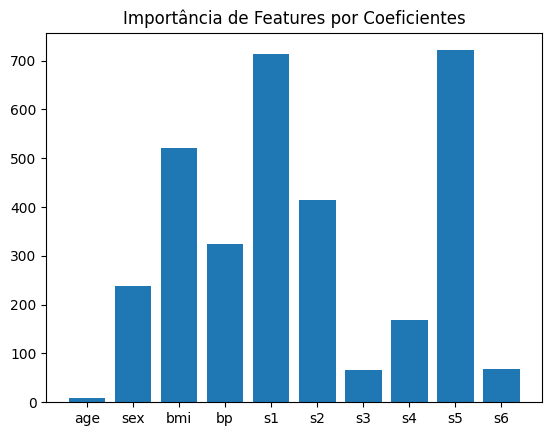

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)

importance = np.abs(ridge.coef_)

feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Importância de Features por Coeficientes")
plt.show()

Vamos importar o ``SelectFromModel`` do sklearn para selecionar as features mais importantes. 

In [6]:
from sklearn.feature_selection import SelectFromModel

# Selecionando features com importância maior que a terceira maior importância
threshold = np.sort(importance)[-3] + 0.01

# Criando o objeto SelectFromModel e selecionando as features
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)


print(f"Features selecionadas pelo SelectFromModel: {feature_names[sfm.get_support()]}")

# treinando o modelo com as features selecionadas
ridge.fit(sfm.transform(X), y)


Features selecionadas pelo SelectFromModel: ['s1' 's5']


RidgeCV(alphas=array([1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06]))

## Escolhendo Features/Variáveis com Base em Correlação

Vamos usar a função make_regression do sklearn para criar um conjunto de dados de regressão com 5000 amostras e 20 features. Onde a **coluna 1 é a variável dependente** e as colunas 2 a 20 são as variáveis independentes.

Vamos usar o método ``.corr()`` para calcular a correlação entre as features e o target.

### O Método VarianceThreshold

A função sklearn.feature_selection.r_regression no scikit-learn é usada para calcular o coeficiente de correlação de Pearson entre cada recurso (regressor) e a variável alvo em um problema de regressão. Ela fornece uma pontuação que pode ser usada em um procedimento de seleção de recursos, mas não realiza a seleção de recursos por si só. A função calcula o coeficiente de correlação de Pearson para avaliar o efeito individual de cada recurso na variável alvo. No entanto, é necessário combinar essa função com outras técnicas de seleção de recursos para realizar o processo de seleção completo. Essas técnicas adicionais podem ser parte de um procedimento de seleção de recursos mais amplo.


### Prevenindo Multicolinearidade

Multicolinearidade é a situação em que duas ou mais variáveis independentes estão altamente correlacionadas entre si.
Isso infla os coeficientes das variáveis independentes e torna os resultados instáveis. Diminuindo a precisão do modelo.

In [21]:
# reproduce SelectKBest from scratch
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df_diabetes['target'] = diabetes.target

df_diabetes.corr().sort_values('target', ascending=False)['target']

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [22]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

selector = SelectKBest(r_regression, k=6)


X_new = selector.fit_transform(X, y)

# comparando as formas dos dados
print(X.shape)
print(X_new.shape)

# transformando o array em um dataframe
X_df = pd.DataFrame(X, columns=feature_names)

# colunas selecionadas
colunas_selecionadas = X_df.columns[selector.get_support()]

print(f"As variáveis selecionadas foram: {colunas_selecionadas.values}")

(442, 10)
(442, 6)
As variáveis selecionadas foram: ['bmi' 'bp' 's1' 's4' 's5' 's6']


## Feature Selection em Classificação

Vamos usar o conjunto de dados de câncer de mama do sklearn para selecionar as features mais importantes para classificar se um tumor é benigno ou maligno.

Vamos usar o estimador ``LogisticRegression`` para selecionar as features mais importantes.

LogisticRegression é um estimador linear que usa a função logística para modelar a probabilidade de uma determinada classe ou evento ocorrer. A regressão logística é usada para resolver problemas de classificação binária. A regressão logística pode ser usada para resolver problemas de classificação multiclasse, mas, neste caso, é chamada de regressão logística multinomial.

A função logística é uma função sigmóide que mapeia valores reais para o intervalo [0, 1]. A função logística é definida como:

<!-- MathJax -->

$$f(x) = \frac{1}{1 + e^{-x}}$$

$$f(x) = \frac{e^x}{1 + e^x}$$

Onde:

-   $x$ é o valor de entrada
-   $f(x)$ é o valor de saída

Maximum Likelihood Estimation (MLE) é um método para estimar os parâmetros de um modelo estatístico. O objetivo do MLE é encontrar os valores dos parâmetros que maximizam a probabilidade de observar os dados fornecidos. O MLE é usado para estimar os parâmetros de um modelo de regressão logística.

A função logística é usada para calcular a probabilidade de uma determinada classe ou evento ocorrer. Por exemplo, se estivéssemos tentando prever se um tumor é benigno ou maligno, a função logística nos daria a probabilidade de um tumor ser benigno ou maligno.

A função logística é uma função sigmóide, o que significa que sua curva de gráfico tem uma forma de S. A função logística é uma função não linear, o que significa que não podemos representá-la como uma combinação linear de seus parâmetros.

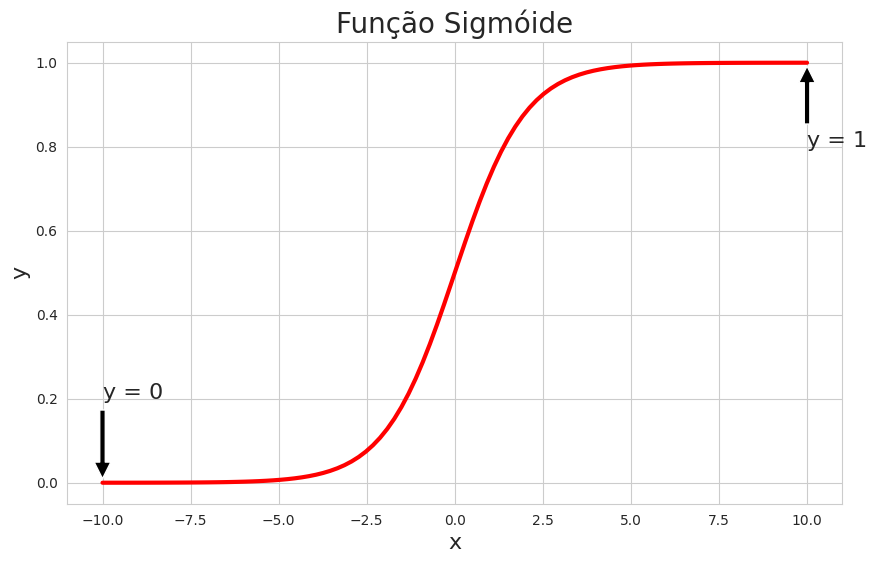

In [8]:
# Draw sigmoid function on sns
sns.set_style("whitegrid")

#criando os dados usando a np.linspace que cria um array com 100 valores igualmente espaçados entre -10 e 10
x = np.linspace(-10, 10, 100)

# calculando a função sigmoide
y = 1 / (1 + np.exp(-x))

plt.figure(figsize=(10, 6))

plt.plot(x, y, color='red', lw=3)

plt.xlabel('x', fontsize=16)

plt.ylabel('y', fontsize=16)

plt.title('Função Sigmóide', fontsize=20)
plt.annotate('y = 1', xy=(10, 1), xytext=(10, 0.8), fontsize=16, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('y = 0', xy=(-10, 0), xytext=(-10, 0.2), fontsize=16, arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


No scikit-learn, especificamente no módulo sklearn.feature_selection, as funções ``chi2`` e ``f_classif`` são métodos de seleção de características estatísticas que podem ser usados para selecionar recursos relevantes em tarefas de classificação. No entanto, eles diferem em termos das estatísticas usadas e das suposições subjacentes.

### ``chi2`` (Qui-quadrado):

O teste Qui-quadrado é uma medida estatística que avalia a independência entre duas variáveis categóricas.

**É aplicável quando a variável alvo (variável de resposta) é categórica e as variáveis de entrada são discretas.**

A função ``chi2`` do ``sklearn.feature_selection`` calcula as estatísticas de qui-quadrado entre cada recurso e a variável alvo.
A pontuação de qui-quadrado indica o quão bem cada recurso está relacionado à variável alvo.
Valores maiores de qui-quadrado indicam uma maior dependência entre o recurso e a variável alvo.

### ``f_classif`` (Análise de Variância):

A análise de variância (ANOVA) é uma técnica estatística que compara as médias entre dois ou mais grupos para determinar se há diferenças significativas entre eles.
A função f_classif do sklearn.feature_selection calcula a estatística F entre cada recurso e a variável alvo.

**É aplicável quando a variável alvo é categórica e as variáveis de entrada são contínuas.**

A estatística F mede a relação linear entre cada recurso e a variável alvo, assumindo que as amostras são independentes e seguem uma distribuição normal.


Em resumo, a principal diferença entre ``chi2`` e ``f_classif`` está nas estatísticas subjacentes que são usadas para calcular a relevância dos recursos em relação à variável alvo. O ``chi2`` é adequado para variáveis categóricas, enquanto o ``f_classif`` é adequado para variáveis contínuas. 
**Portanto, a escolha entre esses métodos depende da natureza dos seus dados e do tipo de variáveis envolvidas na tarefa de classificação.**

In [16]:
# Feature Selection for Classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.datasets import load_breast_cancer

# carregando os dados
data = load_breast_cancer()
X, y = data.data, data.target

print(data.DESCR)


.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [20]:
X_df = pd.DataFrame(X, columns=data.feature_names)

X_df.head() 

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


(569, 30)
(569, 3)


<AxesSubplot: >

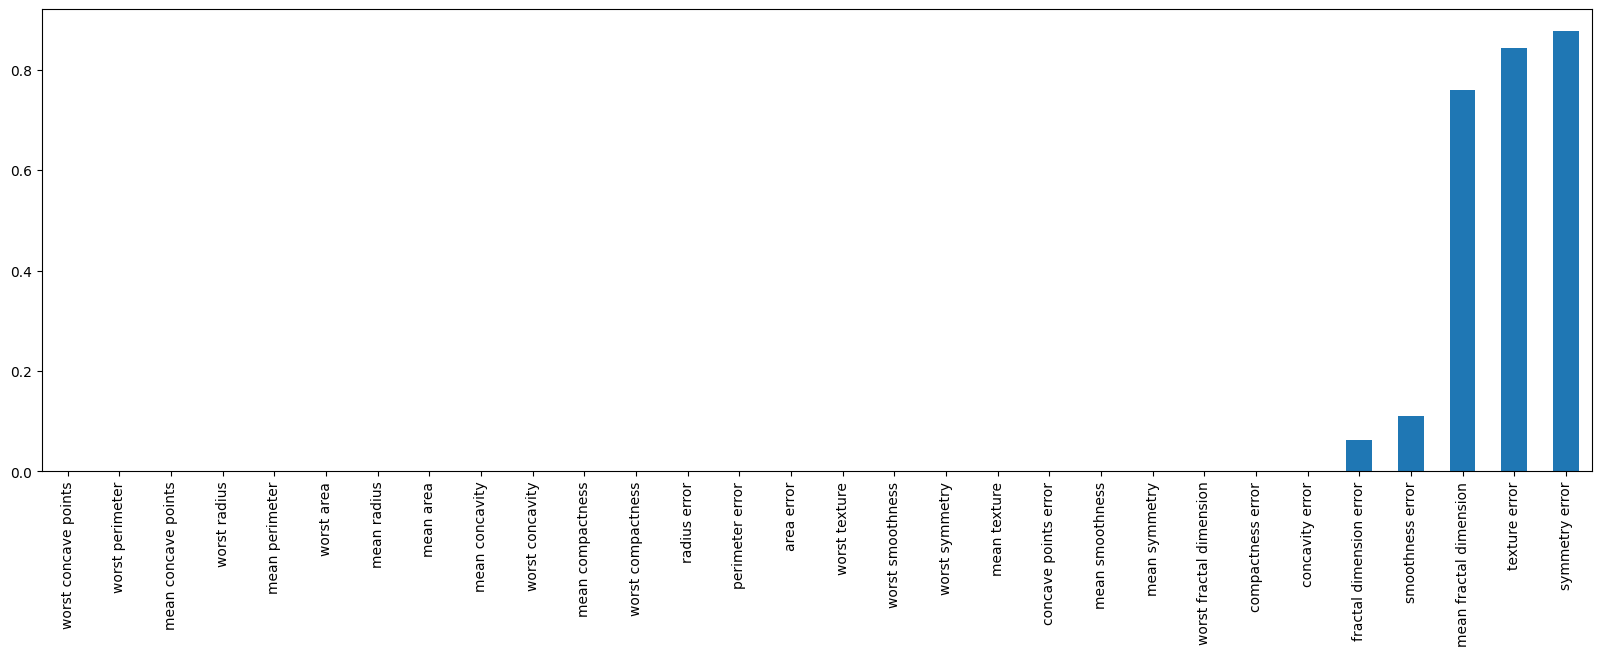

In [32]:
# aplicando o teste qui-quadrado
f_selector = SelectKBest(f_classif, k=3)
X_kbest = f_selector.fit_transform(X, y)

# comparando as formas dos dados
print(X.shape)
print(X_kbest.shape)

X_df = pd.DataFrame(X, columns=data.feature_names)

# as colunas selecionadas
colunas_selecionadas = X_df.columns[f_selector.get_support()]

# todas as colunas
todas_colunas = X_df.columns

# sort the values from low to high
pvalues = pd.Series(f_selector.pvalues_)
pvalues.index = todas_colunas
pvalues.sort_values(ascending=True, inplace=True)

pvalues.plot.bar(figsize=(20, 6))

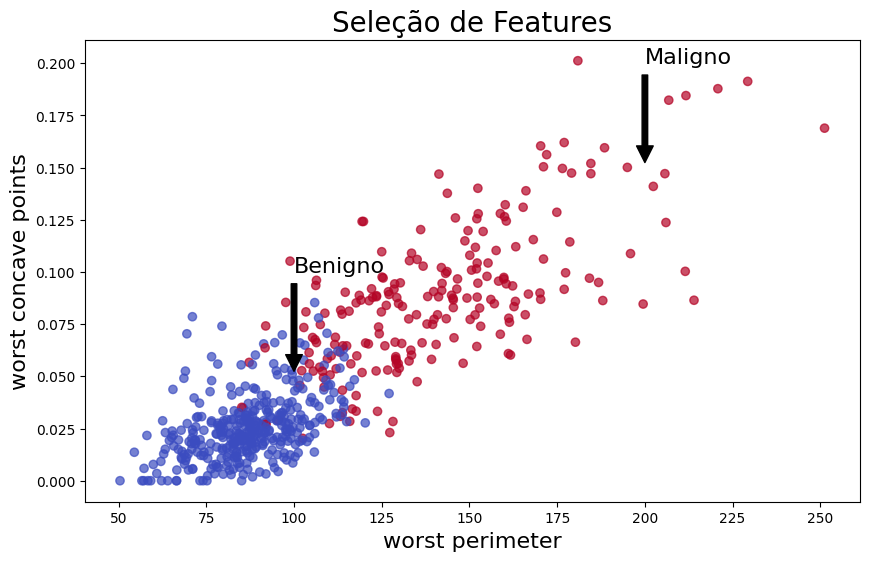

In [43]:
# plotando as duas variáveis selecionadas
plt.figure(figsize=(10, 6))

plt.scatter(X_kbest[:, 1], X_kbest[:, 0], c=y, cmap='coolwarm_r', alpha=0.7)

plt.xlabel('worst perimeter', fontsize=16)

plt.ylabel('worst concave points', fontsize=16)

plt.title('Seleção de Features', fontsize=20)

## annotate plot
plt.annotate('Maligno', xy=(200, 0.15), xytext=(200, 0.2), fontsize=16, arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Benigno', xy=(100, 0.05), xytext=(100, 0.1), fontsize=16, arrowprops=dict(facecolor='black', shrink=0.05))


plt.show()